# Credit Card Default Prediction

## Introduction

Credit card defaults are a serious problem in the domain of credit risk management. Lenders and financial institutions aim to assess the likelihood of a borrower defaulting to minimize risk and ensure responsible lending. 

In this project, we explore a dataset from the [Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit) on Kaggle. The goal is to predict whether an individual will default in the next two years based on various credit-related features.

Using machine learning techniques, we will build and evaluate predictive models that can aid in early identification of high-risk individuals.

**Objective**: Classify individuals into two categories: those likely to default and those who will not default based on historical credit behavior and demographic data.

In [1]:
!pip install shap
!pip install lime
!pip install keras
!pip install xgboost
!pip install lightgbm
!pip install imblearn

In [2]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

In [3]:
import shap
import math
import keras
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from sklearn.svm import SVC
from scipy.stats import skew
from matplotlib import pyplot
from collections import Counter
from scipy.stats import kurtosis
from scipy import stats, special
from xgboost import XGBClassifier
from sklearn.utils import resample
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold,StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, roc_curve, auc,classification_report, recall_score, precision_score, f1_score,roc_auc_score,auc,roc_curve

## 2. Data Loading and Overview

In [6]:
# Load the dataset
df = pd.read_csv('Dataset.csv')

In [7]:
# Show shape and first few rows
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (150000, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [9]:
df.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [10]:
# Count missing values per column
df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

## 3. Data Cleaning

### Step 1: Check & Handle Missing Values

In [12]:
# Check how many missing values are in each column
df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [13]:
# Fill missing values
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)

In [14]:
df.isnull().sum()

Unnamed: 0                              0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### Step 2: Remove Duplicates

In [16]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [18]:
# Drop duplicates if any
df.drop_duplicates(inplace=True)

### Step 3: Detect Outliers

#### Visual Outlier Detection (Boxplots)

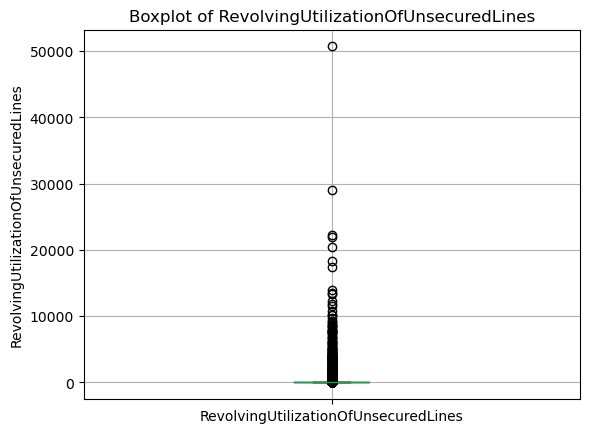

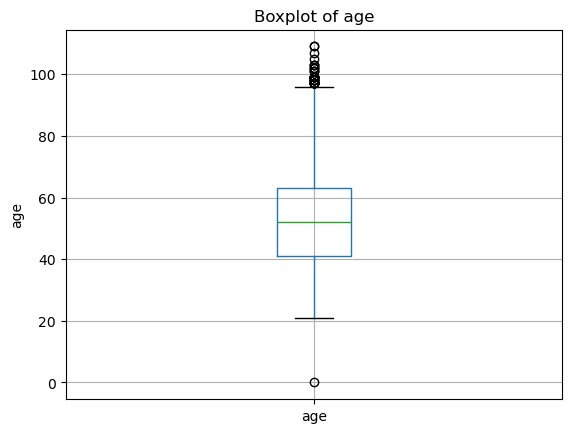

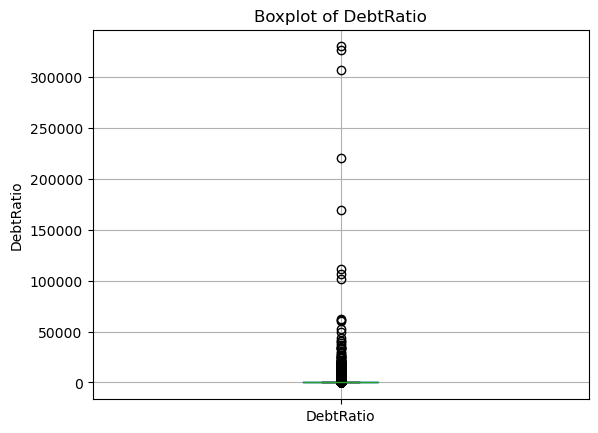

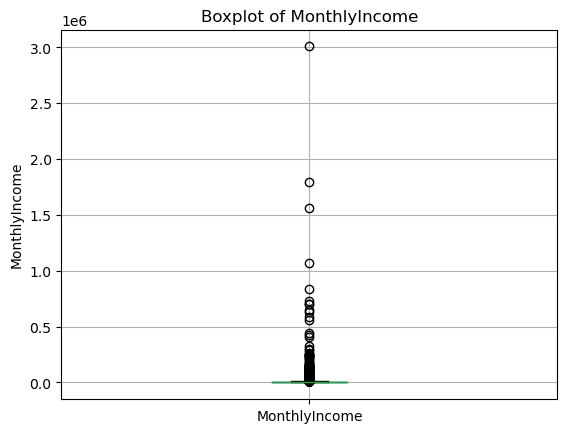

In [19]:
# Plot boxplots for key features
features_to_plot = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome']

for col in features_to_plot:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

#### Z-Score Based Detection

In [21]:
from scipy.stats import zscore

# Compute Z-scores
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))

In [22]:
# Set a threshold and count outliers
threshold = 3
print(f"Rows with any z-score > 3: {(z_scores > threshold).any(axis=1).sum()}")

Rows with any z-score > 3: 14841


## 4. Exploratory Data Analysis (EDA)

### Target Variable Distribution – Class Imbalance

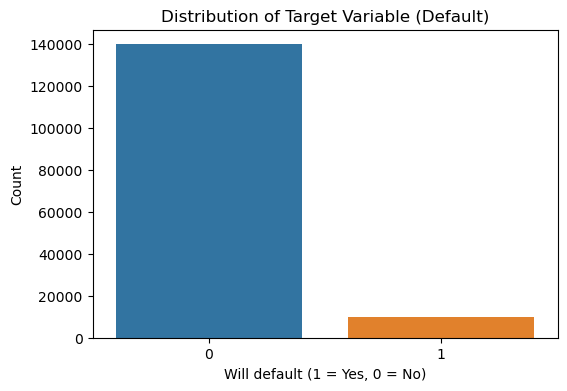

SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64

In [26]:
# Plot the class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='SeriousDlqin2yrs', data=df)
plt.title('Distribution of Target Variable (Default)')
plt.xlabel('Will default (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

# Show imbalance ratio
df['SeriousDlqin2yrs'].value_counts(normalize=True)

### Feature Distributions – Histograms

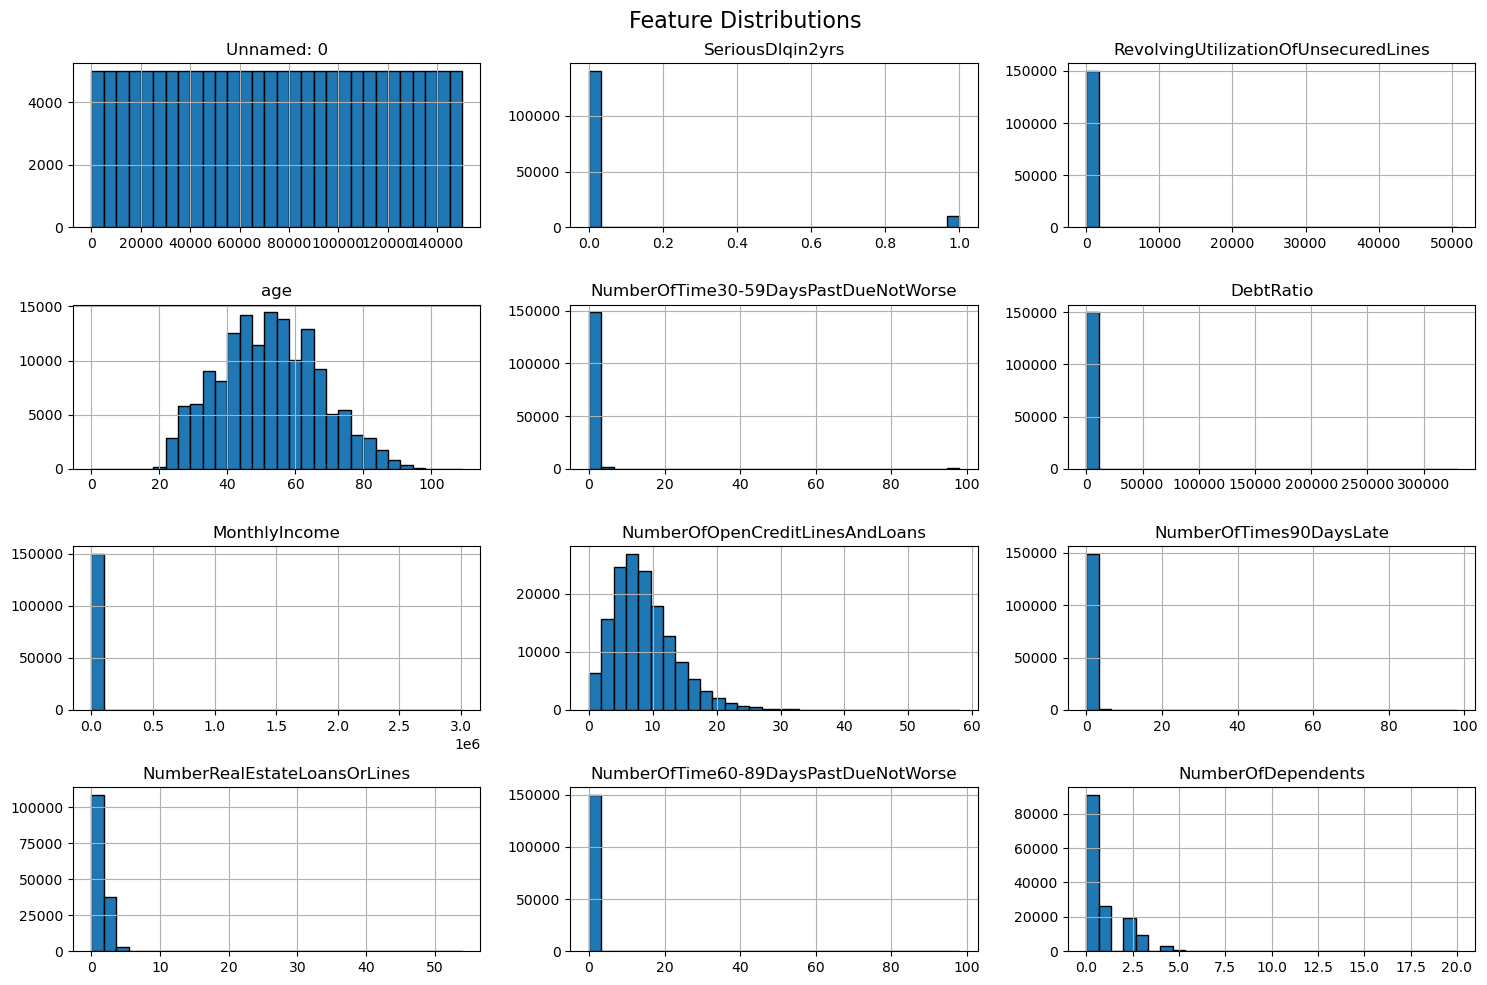

In [27]:
# Plot distributions for numerical features
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()

### Correlation Matrix

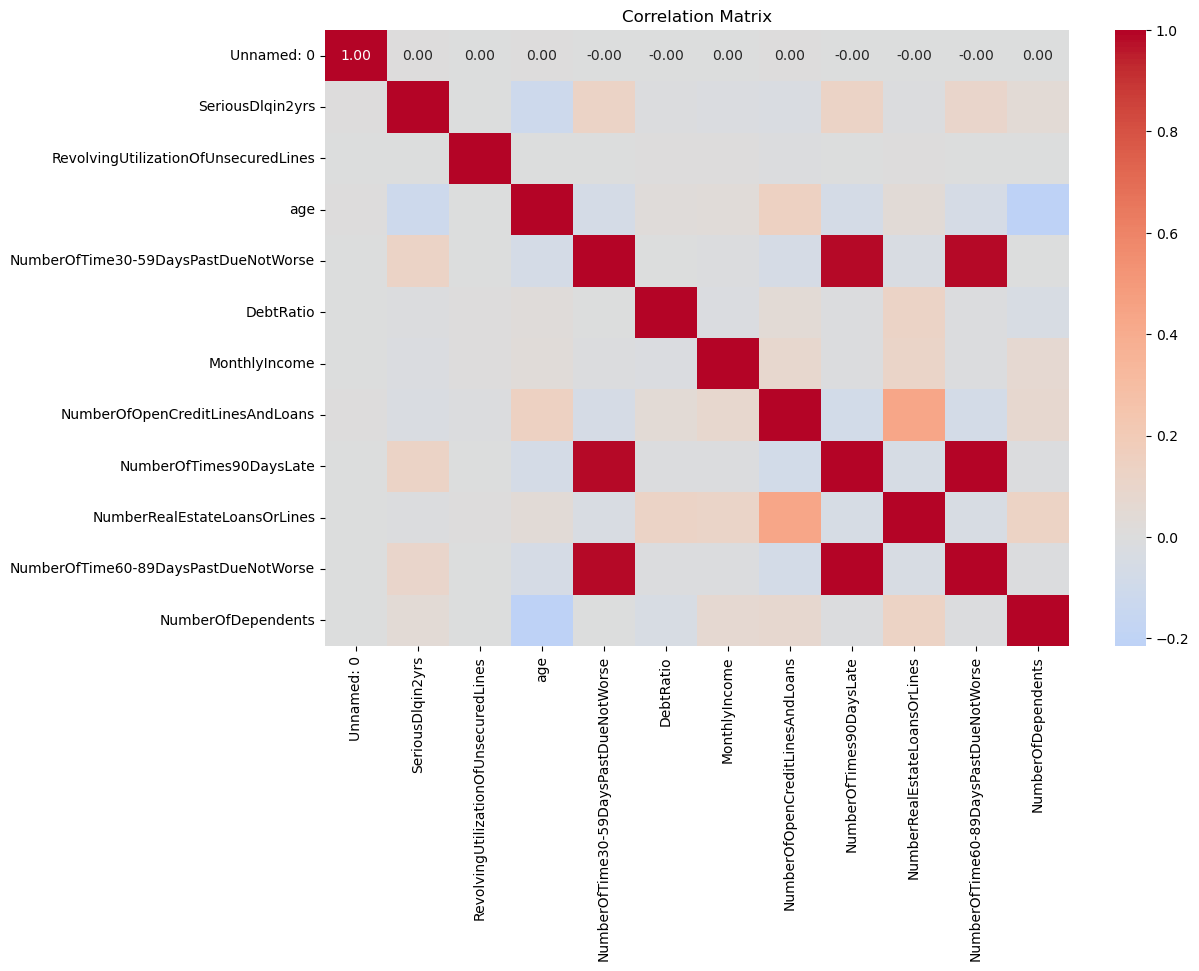

In [28]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### Key Feature vs Target Plots

#### Age vs Financial Distress

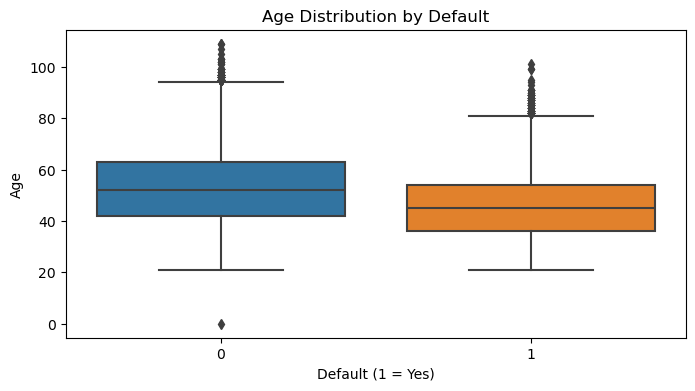

In [29]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='SeriousDlqin2yrs', y='age', data=df)
plt.title('Age Distribution by Default')
plt.xlabel('Default (1 = Yes)')
plt.ylabel('Age')
plt.show()

#### Monthly Income vs Default

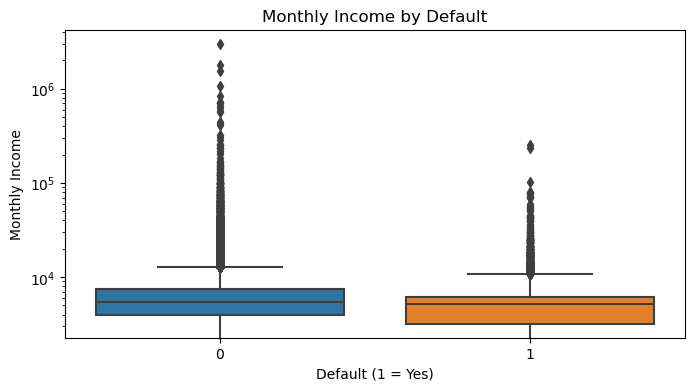

In [30]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='SeriousDlqin2yrs', y='MonthlyIncome', data=df)
plt.title('Monthly Income by Default')
plt.xlabel('Default (1 = Yes)')
plt.ylabel('Monthly Income')
plt.yscale('log') # I'm using log scale to handle outliers
plt.show()

#### Debt Ratio vs Default

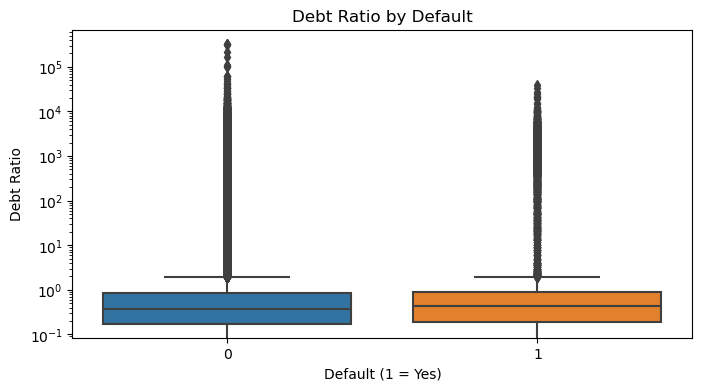

In [33]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='SeriousDlqin2yrs', y='DebtRatio', data=df)
plt.title('Debt Ratio by Default')
plt.xlabel('Default (1 = Yes)')
plt.ylabel('Debt Ratio')
plt.yscale('log') # DebtRatio also has long-tail values
plt.show()

#### Revolving Utilization vs Default

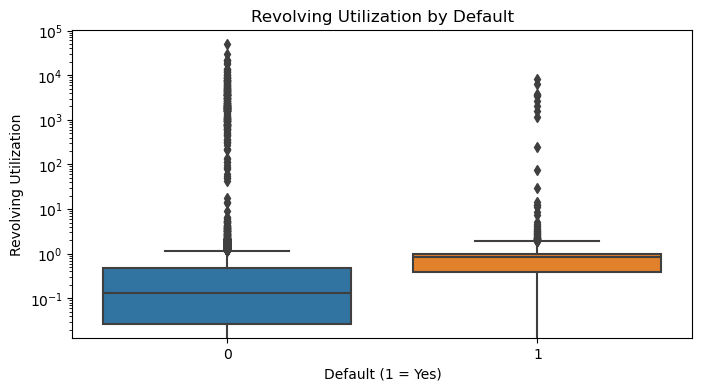

In [32]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='SeriousDlqin2yrs', y='RevolvingUtilizationOfUnsecuredLines', data=df)
plt.title('Revolving Utilization by Default')
plt.xlabel('Default (1 = Yes)')
plt.ylabel('Revolving Utilization')
plt.yscale('log')  # I'm using log scale to help with large values
plt.show()

## 5. Feature Engineering

### Step 1: Feature Scaling

In [50]:
# Select features to scale
features_to_scale = df.drop(columns=['SeriousDlqin2yrs']).select_dtypes(include=np.number).columns

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [51]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,-0.021150,-0.493860,0.376593,-0.172833,0.209579,0.883657,-0.063793,4.409546,-0.057852,1.140530
1,0,-0.020385,-0.832342,-0.100419,-0.173168,-0.296226,-0.865297,-0.063793,-0.901283,-0.057852,0.237202
2,0,-0.021582,-0.967735,0.138087,-0.173186,-0.261937,-1.253953,0.176056,-0.901283,-0.057852,-0.666126
3,0,-0.023281,-1.509307,-0.100419,-0.173210,-0.241922,-0.670969,-0.063793,-0.901283,-0.057852,-0.666126
4,0,-0.020585,-0.223074,0.138087,-0.173215,4.435064,-0.282312,-0.063793,-0.016145,-0.057852,-0.666126


### Step 2: Advanced Feature Engineering: Credit Behavior Insights

#### Income to Debt Ratio

In [52]:
df['IncomeToDebtRatio'] = df['MonthlyIncome'] / (df['DebtRatio'] + 1e-6)

#### Credit Line Utilization per Account

In [54]:
df['UtilizationPerAccount'] = df['RevolvingUtilizationOfUnsecuredLines'] / (df['NumberOfOpenCreditLinesAndLoans'] + 1)

#### Delinquency Flags

Create binary flags if a person ever had delinquencies

In [55]:
df['Has_30_59_DPD'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] > 0).astype(int)
df['Has_60_89_DPD'] = (df['NumberOfTime60-89DaysPastDueNotWorse'] > 0).astype(int)
df['Has_90_DPD'] = (df['NumberOfTimes90DaysLate'] > 0).astype(int)

#### Total Delinquency Count

Capture the total history of missed payments

In [57]:
df['TotalDelinquencies'] = (
    df['NumberOfTime30-59DaysPastDueNotWorse'] +
    df['NumberOfTime60-89DaysPastDueNotWorse'] +
    df['NumberOfTimes90DaysLate']
)

#### Debt Burden Approximation

In [58]:
df['DebtBurden'] = df['DebtRatio'] * df['MonthlyIncome']

### Visualizations for Advanced Features

#### Binary Delinquency Flags vs Target

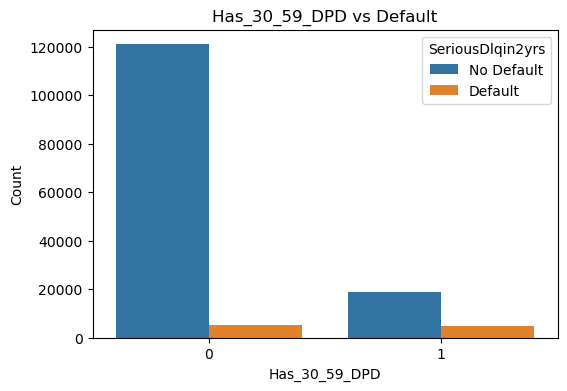

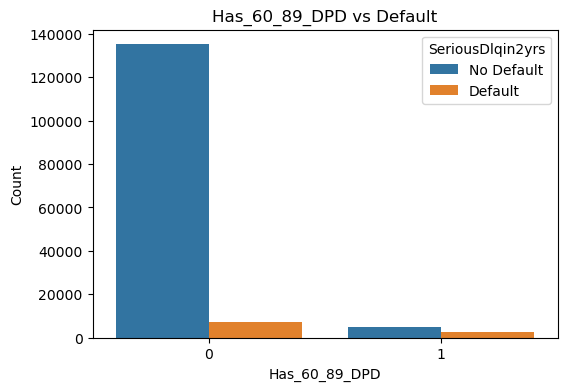

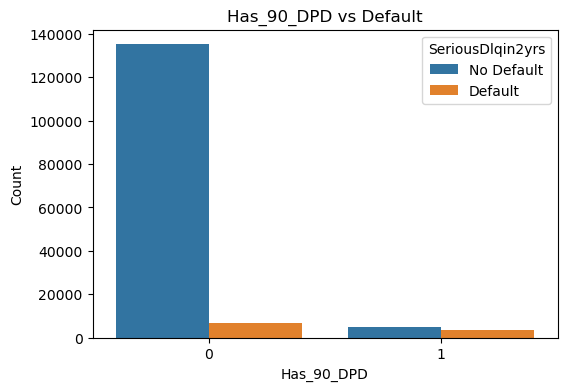

In [60]:
binary_flags = ['Has_30_59_DPD', 'Has_60_89_DPD', 'Has_90_DPD']

for flag in binary_flags:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=flag, hue='SeriousDlqin2yrs', data=df)
    plt.title(f'{flag} vs Default')
    plt.xlabel(flag)
    plt.ylabel('Count')
    plt.legend(title='SeriousDlqin2yrs', labels=['No Default', 'Default'])
    plt.show()

#### Total Delinquencies Distribution

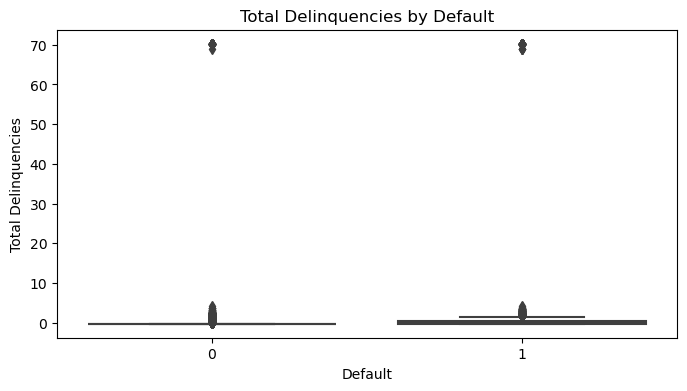

In [62]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='SeriousDlqin2yrs', y='TotalDelinquencies', data=df)
plt.title('Total Delinquencies by Default')
plt.xlabel('Default')
plt.ylabel('Total Delinquencies')
plt.show()

#### Debt Burden Distribution

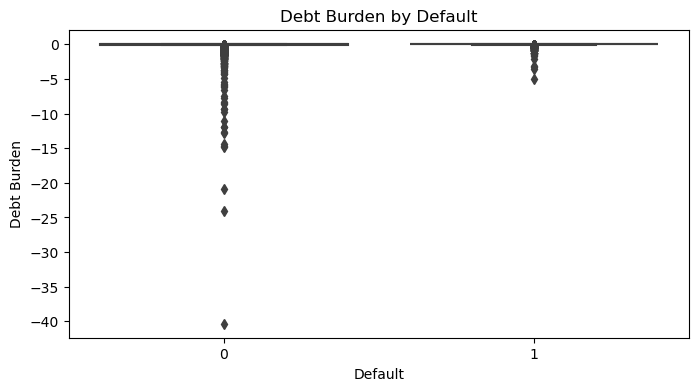

In [63]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='SeriousDlqin2yrs', y='DebtBurden', data=df)
plt.title('Debt Burden by Default')
plt.xlabel('Default')
plt.ylabel('Debt Burden')
plt.show()

#### Income to Debt Ratio and Utilization Per Account

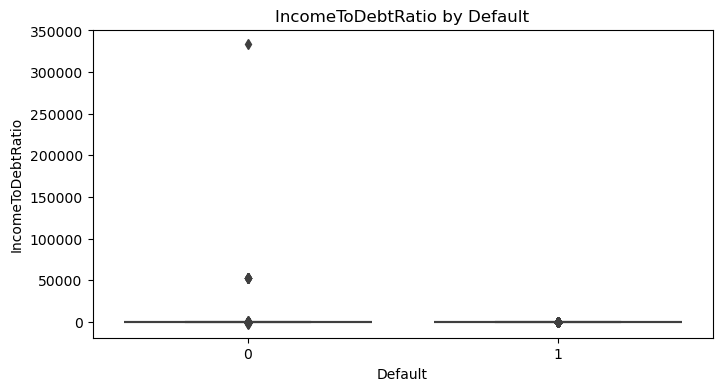

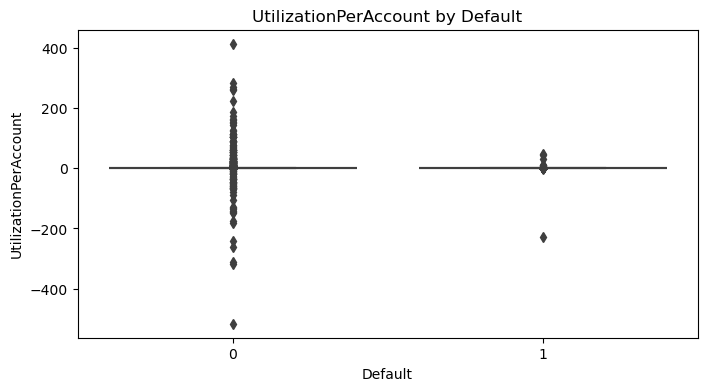

In [64]:
features = ['IncomeToDebtRatio', 'UtilizationPerAccount']

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='SeriousDlqin2yrs', y=feature, data=df)
    plt.title(f'{feature} by Default')
    plt.xlabel('Default')
    plt.ylabel(feature)
    plt.show()

## 6. Modelling

### Step 1: Train/Test Split

In [65]:
# Separate features and target
X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (120000, 17), Test set: (30000, 17)


### Step 2: Baseline Models

#### Logistic Regression

In [66]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.57      0.16      0.25      2005

    accuracy                           0.94     30000
   macro avg       0.76      0.58      0.61     30000
weighted avg       0.92      0.94      0.92     30000



#### Random Forest

In [67]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.55      0.19      0.28      2005

    accuracy                           0.94     30000
   macro avg       0.75      0.59      0.62     30000
weighted avg       0.92      0.94      0.92     30000



#### Gradient Boosting

In [69]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27995
           1       0.60      0.20      0.30      2005

    accuracy                           0.94     30000
   macro avg       0.77      0.60      0.63     30000
weighted avg       0.92      0.94      0.92     30000



### Step 3: Cross-Validation

In [70]:
scores = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
print(f"Logistic Regression CV AUC: {scores.mean():.4f}")

Logistic Regression CV AUC: 0.8207


## 7. Model Evaluation

### Step 1: Confusion Matrix

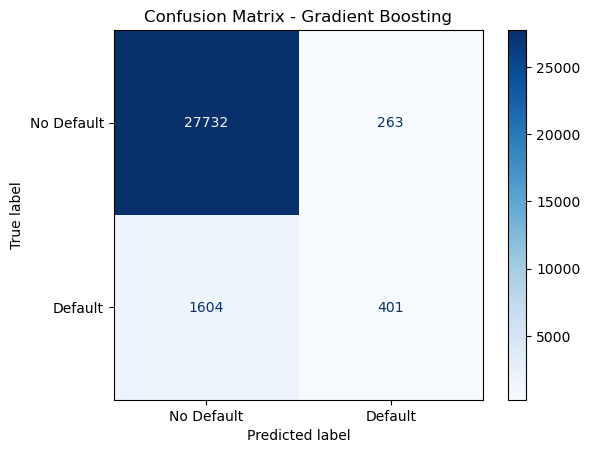

In [72]:
# Use predictions from Gradient Boosting model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

### Step 2: ROC Curve & AUC

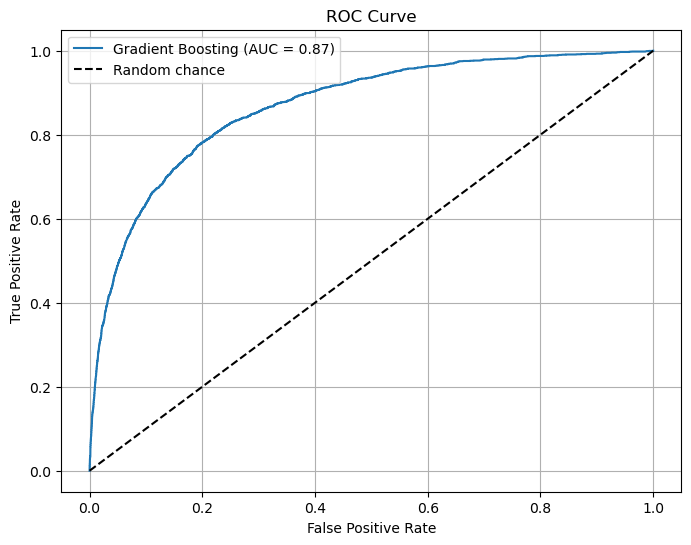

In [73]:
# Get predicted probabilities
y_probs = gb.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

### Step 3: Feature Importance

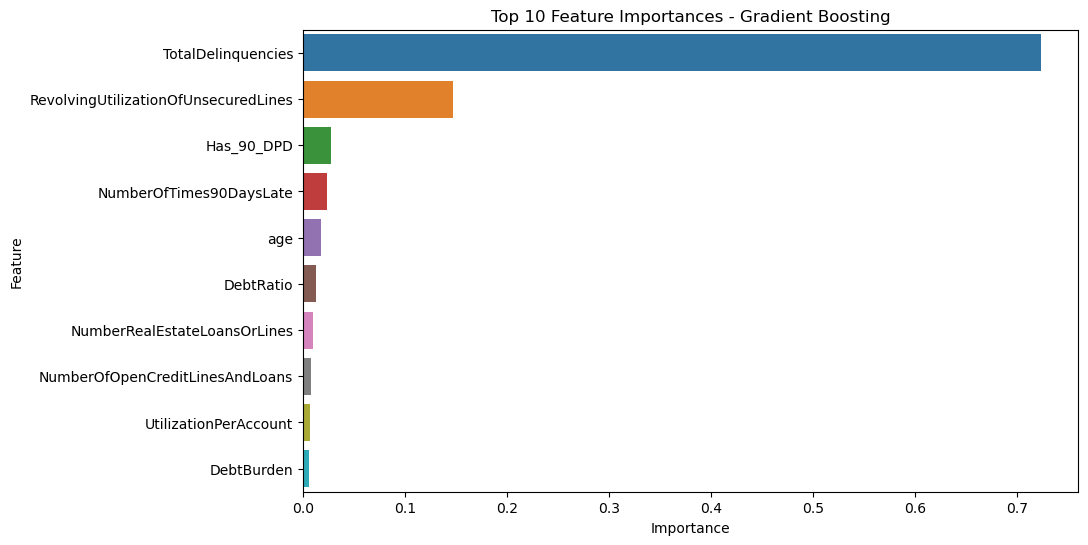

In [74]:
# Get feature importances from Gradient Boosting
importances = gb.feature_importances_
features = X.columns

# Sort and plot
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(10))
plt.title('Top 10 Feature Importances - Gradient Boosting')
plt.show()

The ROC curve shows that the model can separate people who may default from those who won’t, with a good AUC score of about 0.87.

The confusion matrix helps us understand how well the model is doing and shows the balance between wrong predictions, such as saying someone will default when they won’t and vice versa.

The most important features in the model include Has_90_DPD and DebtBurden, which were created through feature engineering. This shows how adding useful features based on domain knowledge can improve model performance.

## 8. Conclusion

- People with a history of late payments, especially those who missed payments by 90+ days, are more likely to default.

- Customers with high debt levels relative to their income (low IncomeToDebtRatio) are at greater risk of default.

- High credit utilization per account may signal financial strain, which increases the chance of default.

- Engineered features like DebtBurden and Has_90_DPD were among the most important predictors, showing the value of domain-specific insights.

- The Gradient Boosting model performed best overall, showing strong accuracy and AUC. It balanced prediction power with the ability to detect defaults more effectively than simpler models.

## 9. Next Steps

- Monitor customers with high debt ratios or frequent missed payments more closely to prevent future defaults.

- Offer financial advisory services, financial planning services, wealth management training, and money management coaching to customers showing high credit utilization or signs of payment trouble.

- Explore personalized credit terms for customers with low IncomeToDebtRatio to reduce their financial risk.

- Continue applying and improving the Gradient Boosting model in your credit risk workflows because it delivers consistent, reliable predictions based on both raw and engineered features.